In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image
import os
import time
import matplotlib.pyplot as plt
import utils

## To-do

- Method to create an adversarial dataset
    - input should be the filename of where the created dataset will be stored. Save as a pickle?
- You'll need to write somewhere a function that takes as input the saved pickle and 
    creates a Pytorch dataset/dataloader from it. 
    - This will take as input the path to the pickle
    - Optional input arguments: the original class and the target class. You'll have to do 
        some subsetting/slicing for this. Should be very straightforward


## Creating an adversarial image dataset

- Have two functions that both take in the same argument: a filename where dataset will be stored
    - One that writes/creates dataset
    - One that reads the saved file and returns something -- either a numpy array or a pytorch dataloader
- For the function that reads the dataset, have an optional arugment be a (original, target) pair, and it will return only images whose true label is original and whose adversary causes the model to predict target




In [3]:
class Adversarial_utils:
    '''
    Class that helps to experiment with adversarial 
    image generation. Also contains functionality to 
    create an adversarial image dataset
    '''
    def __init__(self, dataset):
        assert (dataset == 'cifar' or dataset == 'mnist'), \
            'Dataset must either be \'cifar\' or \'mnist\''
        self.dataset = dataset
        self.data = utils.get_data(dataset)
        self.model = utils.trained_model(dataset)
    
    def fool_calibrate(self, 
                       target, 
                       epsilon=1e-2, 
                       num_iters=100, 
                       max_L2_norm=None, 
                       drop_failures=True,
                       verbose=True):
        '''
        Generate a set of adversarial images from a random batch of data
        '''
        images, labels = iter(self.data).next()
        images, labels = images.clone(), labels.clone()
        
        self.calibrate_data = self.fool(images, 
                                        labels, 
                                        target, 
                                        epsilon=epsilon, 
                                        num_iters=num_iters, 
                                        max_L2_norm=max_L2_norm,
                                        calibrate=True,
                                        drop_failures=drop_failures, 
                                        verbose=verbose)
        self._visualize(target)

    def _visualize(self, target):
        '''
        Visualize the adversarial images and perturbations generated 
        with fool_calibrate()
        '''
        a,b,c,d,e,f,g = self.calibrate_data
        original_images, pert_images, adv_images = a, b, c
        original_labels, target_labels = d, e
        required_iters, pert_norm = f,g
        predictions = torch.argmax(self.model(adv_images),1)

        for i in range(len(adv_images)):
            pred = predictions[i].clone()
            label = original_labels[i].clone()
            required_iter = required_iters[i].clone()
            norm = pert_norm[i].clone()
            adv_im = adv_images[i].clone()
            pert_im = pert_images[i].clone()
            original_im = original_images[i].clone()
            
            # In order to plot, normalize so pixels are in range [0,1]
            pert_im = pert_im - pert_im.min()
            pert_im = pert_im/pert_im.max()
            
            if self.dataset == 'cifar':
                _cmap = None
                adv_im = adv_im.squeeze(0).numpy().transpose((1,2,0))
                pert_im = pert_im.squeeze(0).numpy().transpose((1,2,0))
                original_im = original_im.squeeze(0).numpy().transpose((1,2,0))
            
            if self.dataset == 'mnist':
                _cmap = 'binary_r'
                adv_im = adv_im.squeeze(0).numpy()
                pert_im = pert_im.squeeze(0).numpy()
                original_im = original_im.squeeze(0).numpy()
            
            print('Original Label: {}'.format(label))
            print('Model prediction: {}'.format(pred))

            # Plot adversary
            plt.subplot(1,3,1)
            plt.imshow(adv_im, cmap=_cmap)
            plt.title('Adversary')
            plt.xticks([])
            plt.yticks([])

            # Plot perturbation
            plt.subplot(1,3,2)
            plt.imshow(pert_im, cmap=_cmap)
            plt.title('Iters: {:.0f}, Norm: {:.3f}'.format(required_iter, norm))
            plt.xticks([])
            plt.yticks([])

            # Plot original
            plt.subplot(1,3,3)
            plt.imshow(original_im, cmap=_cmap)
            plt.title('Original')
            plt.xticks([])
            plt.yticks([])

            plt.show()
            print('\n')

            
    def fool(self, 
             images, 
             labels, 
             target, 
             epsilon=5e-2, 
             num_iters=100, 
             max_L2_norm=None,
             calibrate=False,
             drop_failures=True,
             verbose=False):
        '''
        Generated adversarial images for a batch of data contained in argument images
        '''
        
        start = time.time()  # Keep track of how long this takes
        num = len(images)

        # Take a subset of batch:
        # - only keep images that are correctly classified
        # - only keep images not already belonging to target class
        pred = torch.argmax(self.model(images), 1)
        mask = (pred == labels) * (labels != target)
        images, labels = images[mask], labels[mask]
        original_images, original_labels = images.clone(), labels.clone()

        images.requires_grad_(True)  # very important!
        # We don't need the gradients of anything else
        for param in self.model.parameters():
            param.requires_grad_(False)

        perturbation = torch.zeros_like(images)
        required_iters = torch.ones_like(labels).type(torch.float)
        fooled = False
        iteration = 0

        # Initialize upstream gradients
        dout = torch.zeros_like(self.model(images), dtype=torch.float)
        dout[:,target] = 1.  # only compute gradient w.r.t. target class

        while fooled is False and iteration < num_iters:
            output = self.model(images)
            self.model.zero_grad() # zero out gradients so they don't accumulate
            grad = torch.autograd.grad(outputs=output, 
                                       inputs=images, 
                                       grad_outputs=dout)[0]

            with torch.no_grad():
                proposed_perturbation = epsilon * grad

                # Make sure pixels in resulting image are in [0,1]
                pert_upper_bound = torch.ones_like(images) - images
                pert_lower_bound = - images
                proposed_perturbation = torch.min(proposed_perturbation, pert_upper_bound)
                proposed_perturbation = torch.max(proposed_perturbation, pert_lower_bound)

                # Update images and perturbation
                perturbation.add_(proposed_perturbation)
                images.add_(proposed_perturbation)
                
                # If an example is correctly predicted, set all upward gradients
                # flowing to that example to zero; we've successfully found an
                # adversarial image that tricks the model and no longer need to 
                # update the original. We keep looping to try to find successful
                # adversarial images for the other examples.
                predictions = torch.argmax(self.model(images), 1)
                dout[:,target] = (predictions != target)
                required_iters.add_((predictions != target).type(torch.float))

                # If every adversarial example fooled the model, we're done
                if (predictions == target).sum() == labels.size(0):
                    fooled = True
                iteration += 1

        num_kept = len(images)
        num_terminated = (required_iters < num_iters).sum()
        
        # Only return adversarial images that meet certain criteria
        with torch.no_grad():
            # Only keep images if they successfully fool model
            predictions = torch.argmax(self.model(images),1)
            fool_success = (predictions == target)
            num_fool_success = fool_success.sum()
            if drop_failures:
                mask = fool_success
                images = images[mask]
                labels = labels[mask]
                perturbation = perturbation[mask]
                original_images = original_images[mask]
                original_labels = original_labels[mask]
                required_iters = required_iters[mask]

            # Only keep images if perturbation norms is less than max_L2_norm
            pert_norm = torch.norm(perturbation.view(perturbation.size(0),-1), dim=1)
            if max_L2_norm is not None:
                mask = (pert_norm < max_L2_norm)
                num_ok_pert = mask.sum()
                images = images[mask]
                labels = labels[mask]
                perturbation = perturbation[mask]
                original_images = original_images[mask]
                original_labels = original_labels[mask]
                required_iters = required_iters[mask]
                pert_norm = pert_norm[mask]

        if verbose:
            print('Took {:.2f} seconds'.format(time.time() - start))
            print('Number in batch that model successfully predicts: {}/{}'.format(num_kept, num))
            print('Number that terminated before max number of iterations: {}/{}'.format(num_terminated, num))
            if drop_failures:
                print('Number successfully fooled: {}/{}'.format(fool_success.sum(), num))
            if max_L2_norm is not None:
                print('Number with small enough perturbation: {}/{}'.format(num_ok_pert, num))
            print('\n\n')
        
        target_labels = target * torch.ones_like(original_labels)
        if calibrate:
            return (original_images, perturbation.detach(), images.detach(), original_labels, target_labels,
                    required_iters, pert_norm)
        else:
            return (original_images, perturbation.detach(), images.detach(), original_labels, target_labels)
        
        
    def make_dataset(self, 
                     file_name, 
                     num_examples,
                     epsilon=1e-2,
                     num_iters=100,
                     max_L2_norm=None):
        '''
        Create a dataset of adversarial images
        Arguments:
        - file_name: name of the .npz file where dataset will be stored
        - num_examples: number of examples to include in dataset
        '''
        start = time.time()
        
        originals = list()
        perturbations = list()
        adversaries = list()
        original_labels = list()
        target_labels = list()
        
        running_total = 0
        
        # Iterate through dataset
        for i, (image_batch,label_batch) in enumerate(self.data):
            print('Working on batch {}'.format(i))
            
            # Generate adversarial images for each class label
            for target in range(10):
                batch_data = self.fool(image_batch, label_batch, target, epsilon=epsilon, 
                                       num_iters=num_iters, max_L2_norm=max_L2_norm)
                orig, pert, adv, orig_label, target_label = batch_data
                originals.append(orig.numpy())
                perturbations.append(pert.numpy())
                adversaries.append(adv.numpy())
                original_labels.append(orig_label.numpy())
                target_labels.append(target_label.numpy())
                
            running_total += orig.size(0)
            if running_total > num_examples:
                break
        
        originals = np.concatenate(originals)
        perturbations = np.concatenate(perturbations)
        adversaries = np.concatenate(adversaries)
        original_labels = np.concatenate(original_labels)
        target_labels = np.concatenate(target_labels)
        
        arrays = {'original_images': originals,
                  'perturbations': perturbations,
                  'adversarial_images': adversaries,
                  'original_labels': original_labels,
                  'target_labels': target_labels}
        
        np.savez(file_name, **arrays)
        print('Took {:.2f} minutes'.format( (time.time() - start)/60.0 ))
        

In [ ]:
s = 'test'
if '.npz' not in s:
    s += '.npz'

print(s)


In [ ]:
cifar_adv = Adversarial_utils('cifar')

In [ ]:
cifar_adv.make_dataset('test_cifar_dataset', num_examples=1000)


In [ ]:
class Adversary_Data(Dataset):
    """
    A customized data loader for adversarial images
    """
    def __init__(self, file_name, original_label, target_label):
        """ Intialize the adversarial image dataset
        Args:
        - file_name: name of file where adversarial data is stored
        - original_label: the original label of images
        - target_label: the label that adversaries trick model into predicting
        """
        assert (original_label != target_label), 'Target label must be different from original label!'
        if '.npz' not in file_name:
            file_name += '.npz'
        data = np.load(file_name)
        
        original_labels = data['original_labels']
        target_labels = data['target_labels']
        mask = (original_labels == original_label) * (target_labels == target_label)

        self.original_labels = torch.from_numpy(original_labels[mask])
        self.target_labels = torch.from_numpy(target_labels[mask])
        self.originals = torch.from_numpy(data['original_images'][mask])
        self.perturbations = torch.from_numpy(data['perturbations'][mask])
        self.adversaries = torch.from_numpy(data['adversarial_images'][mask])
        
        self.len = self.originals.size(0)
        print('Lenght of dataset: {}'.format(self.len))
        
    def __getitem__(self, index):
        """
        Get a sample from the dataset
        """
        original = self.originals[index]
        pert = self.perturbations[index]
        adv = self.adversaries[index]
        orig_label = self.original_labels[index].item()
        target_label = self.target_labels[index].item()
        return original, pert, adv, orig_label, target_label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [ ]:
t = Adversary_Data('test_cifar_dataset', 1,7)
    

In [ ]:
len(t)


In [ ]:
for i in range(20):
    plt.subplot(1,2,1)
    plt.imshow(t[i][0].numpy().transpose(1,2,0))
    plt.title('Original')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,2,2)
    plt.imshow(t[i][2].numpy().transpose(1,2,0))
    plt.title('Adversary')
    plt.xticks([])
    plt.yticks([])
    plt.show()


In [ ]:
t = np.load('test_cifar_dataset.npz')

In [ ]:
t.files

In [ ]:
mask = (t['original_labels']==1) * (t['target_labels']==7)
r0 = t['original_images'][mask]
r1 = t['adversarial_images'][mask]


In [ ]:
r0.shape

In [ ]:
for i in range(20):
    plt.subplot(1,2,1)
    plt.imshow(r0[i].transpose(1,2,0))
    plt.title('Original')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,2,2)
    plt.imshow(r1[i].transpose(1,2,0))
    plt.title('Adversary')
    plt.xticks([])
    plt.yticks([])
    plt.show()


In [16]:
t = utils.get_adv_data('test_cifar_dataset', 9, 8)


In [17]:
s = iter(t).next()


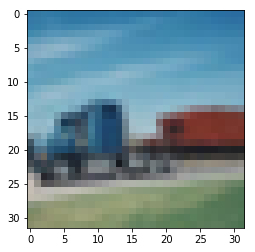

In [24]:

i = 13
plt.imshow(s[0][i].numpy().transpose(1,2,0))
plt.show()


# CIFAR

In [ ]:
cifar_adv = Adversarial_utils('cifar')

In [ ]:
cifar_adv.fool_calibrate(8, epsilon=1e-1, verbose=True)

# MNIST

In [ ]:
mnist_adv = Adversarial_utils('mnist')

In [ ]:
mnist_adv.fool_calibrate(target=4, epsilon=1e-2, num_iters=100, max_L2_norm=3.0)
